In [2]:
import os
import json
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import v2
import random

class OCTDataset(Dataset):
    def __init__(self, root_dir, indices=None, train=True, is_gentuity=False, transform=None, for_augmentation=False):
        
        self.root_dir = Path(root_dir)
        self.train = train
        self.is_gentuity = is_gentuity
        self.transform = transform
        self.for_augmentation = for_augmentation
        
        if self.is_gentuity:
            # Gentuity dataset has separate train and test folders
            split_dir = "train" if self.train else "test"
            self.images_dir = self.root_dir / split_dir / "images"
            self.masks_dir = self.root_dir / split_dir / "annotations"
            self.samples = sorted(self.images_dir.glob("*.tiff"))
        else:
            # Terumo dataset has only train data
            self.images_dir = self.root_dir / "train" / "images"
            self.masks_dir = self.root_dir / "train" / "annotations"
            self.samples = sorted(self.images_dir.glob("*.tiff"))
        
        # Filter image paths using indices if provided
        if indices is not None:
            self.samples = [self.samples[i] for i in indices]
        
        else:
            self.samples = sorted(self.images_dir.glob("*.tiff"))
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load the image
        image_path = self.samples[idx]
        image = Image.open(image_path).convert("RGB")  # Keep it as a PIL Image
        
        # Load the corresponding mask
        mask_path = self.masks_dir / f"{image_path.stem}.json"
        with open(mask_path, "r") as f:
            mask_data = json.load(f)
        
        # Create a binary mask (0 and 1 values)
        mask = np.zeros(image.size[::-1], dtype=np.uint8)  # image.size gives (width, height)
        for coord in mask_data["mask"]:
            x, y = coord
            if 0 <= x < mask.shape[0] and 0 <= y < mask.shape[1]:
                mask[x, y] = 1
        
        mask = Image.fromarray(mask*255)
        
        # Apply the transformation if available
        if self.transform:
            if self.for_augmentation == False:
                # Convert image and mask to Tensor
                image = self.transform(image)
                mask = self.transform(mask)
            else:
                ## For data augmentation ##
                image, mask = self.transform(image, mask)
        
        mask = mask.unsqueeze(0) if len(mask.shape) == 2 else mask  # Add channel if needed
        # Add channel dimension for mask
        if self.for_augmentation == False:
            #mask = mask.unsqueeze(0) if len(mask.shape) == 2 else mask  # Add channel if needed
            unique_id = mask_data["unique_id"]
        else:
            unique_id = 4
        
        
        return image, mask, image_path.stem, unique_id  # Returning image filename too

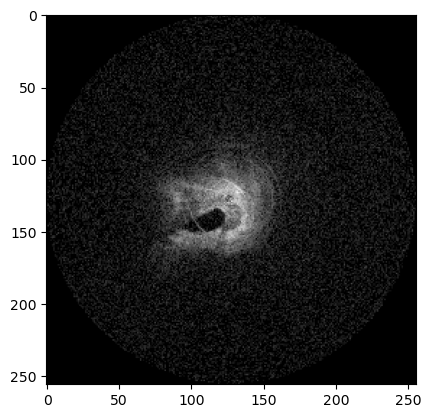

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Define the transformation using Compose
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),   # Resize images to a specific size using nearest interpolation
    transforms.ToTensor(),            # Convert image to Tensor (0 to 1 range)
])

metadata = pd.read_csv(r"C:\Users\rasmu\OneDrive - Aarhus universitet\Deep Learning\data_gentuity\metadata.csv")
skf = StratifiedKFold(n_splits=5)
splits = list(skf.split(metadata, metadata["unique_id"]))
fold = 0
train_indices, val_indices = splits[fold]

# Sanity check for the gentuity data (with train and test folders)
gentuity_data_root = r"C:\Users\rasmu\OneDrive - Aarhus universitet\Deep Learning\data_gentuity"
train_dataset_gentuity = OCTDataset(gentuity_data_root, indices=train_indices, train=True, is_gentuity=True, transform=transform, for_augmentation=False)
val_dataset_gentuity = OCTDataset(gentuity_data_root, indices=val_indices, train=True, is_gentuity=True, transform=transform, for_augmentation=False)

image, mask, _, _ = train_dataset_gentuity[0]
plt.imshow(image.permute(1, 2, 0))


In [3]:
## Augmentation transform composition ##
tensor_transform = v2.Compose([
    v2.Resize((256, 256), interpolation=Image.NEAREST),
    v2.ToTensor(),
])

color_transform = v2.Compose([
    v2.ColorJitter(contrast=0.5, brightness=0.5, saturation=None, hue=None)
])

class SynchronizedRandomRotation:
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, img, label):
        # Generate a random angle for rotation
        angle = v2.RandomRotation.get_params([-self.degrees, self.degrees])

        # Rotate both image and label by the same angle
        img = v2.functional.rotate(img, angle)
        label = v2.functional.rotate(label, angle)

        return img, label


class CombinedTransform:
    def __init__(self, tensor_transform, color_transform, random_rotation):
        self.tensor_transform = tensor_transform
        self.color_transform = color_transform
        self.random_rotation = random_rotation

    def __call__(self, img, label):
        img, label = self.tensor_transform(img, label)
        img = self.color_transform(img)
        img, label = self.random_rotation(img, label)

        return img, label

# Instantiate the combined transform
combined_transform = CombinedTransform(
    tensor_transform=tensor_transform,
    color_transform=color_transform,
    random_rotation=SynchronizedRandomRotation(degrees=180)
)


c:\Users\rasmu\anaconda3\envs\DL\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


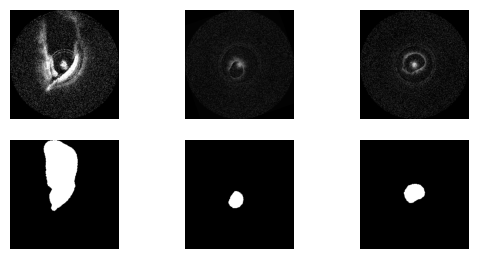

In [4]:
# Apply augmentation to the training dataset
sample_size = len(train_dataset_gentuity)//3
# Randomly sample a subset of the training dataset
aug_indices = np.random.choice(train_indices, sample_size, replace=False)
# Create a new dataset for augmentation
aug_dataset = OCTDataset(gentuity_data_root, indices=aug_indices, train=True, is_gentuity=True, transform=combined_transform, for_augmentation=True)

# Plot the augmented images
for i in range(3):
    image, mask, _, _ = aug_dataset[i]
    # Plot the images next to the masks
    plt.subplot(3, 3, i+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")
    plt.subplot(3, 3, i+4)
    plt.imshow(mask.squeeze(), cmap="gray")
    plt.axis("off")


In [5]:
# Add the augmented dataset to the training dataset
train_dataset_gentuity = torch.utils.data.ConcatDataset([train_dataset_gentuity, aug_dataset])

# Check the new length of the training dataset
print(len(train_dataset_gentuity))

1680


In [ ]:

train_dataset_gentuity.transform = transform  # Reset to original transform
test_dataset_gentuity = OCTDataset(gentuity_data_root, train=False, is_gentuity=True, transform=transform)

train_loader_gentuity = DataLoader(train_dataset_gentuity, batch_size=4, shuffle=True)
test_loader_gentuity = DataLoader(test_dataset_gentuity, batch_size=4, shuffle=True)

# Sanity check for the terumo data (with only train folder)
terumo_data_root = r"C:\Users\rasmu\OneDrive - Aarhus universitet\Deep Learning\data_terumo"
train_dataset_terumo = OCTDataset(terumo_data_root, train=True, is_gentuity=False, transform=transform)

train_loader_terumo = DataLoader(train_dataset_terumo, batch_size=4, shuffle=True)

Sanity check for gentuity train dataset:
Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])
Single image shape: torch.Size([3, 256, 256])
Single mask shape: torch.Size([1, 256, 256])
Unique ID: 1


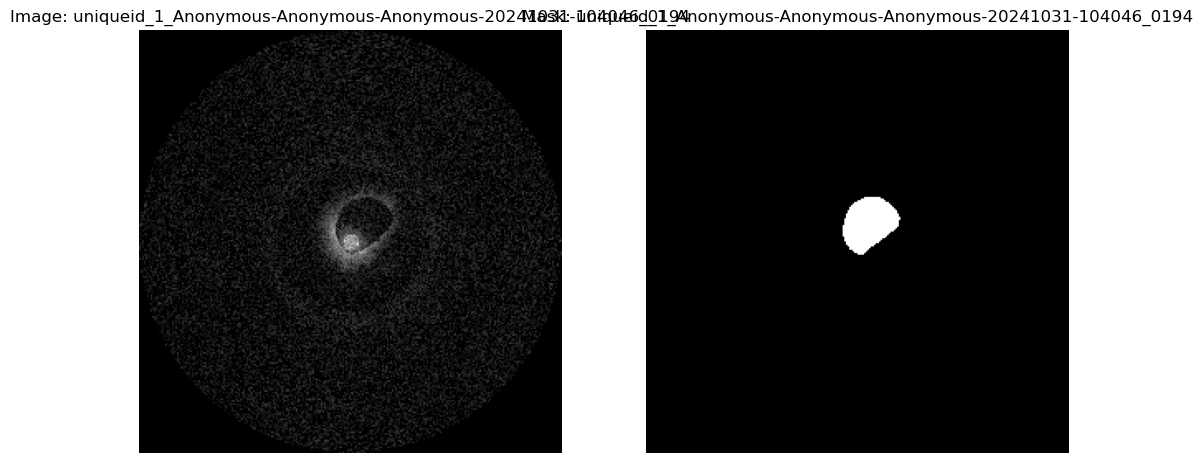


Sanity check for gentuity test dataset:
Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])
Single image shape: torch.Size([3, 256, 256])
Single mask shape: torch.Size([1, 256, 256])
Unique ID: 0


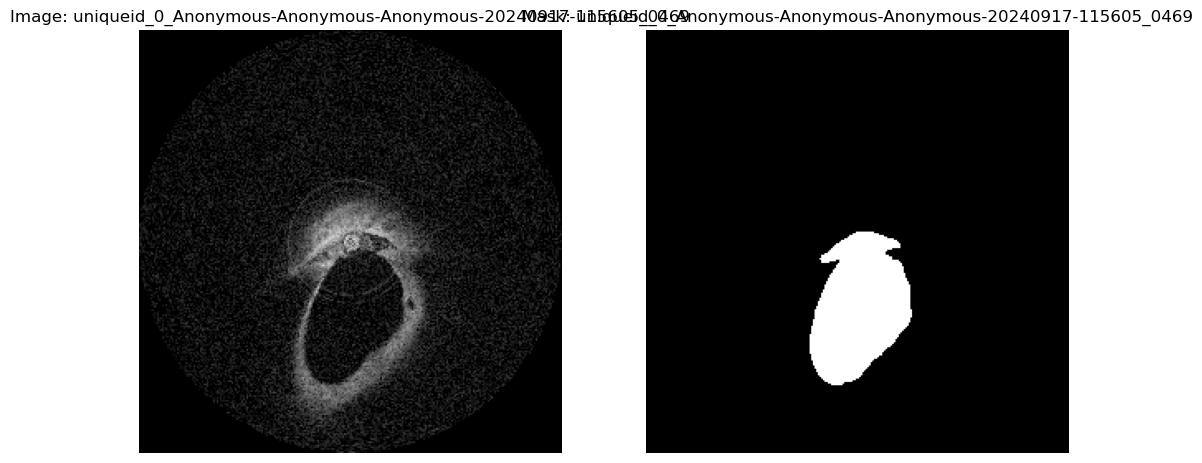


Sanity check for terumo dataset:
Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])
Single image shape: torch.Size([3, 256, 256])
Single mask shape: torch.Size([1, 256, 256])
Unique ID: 1


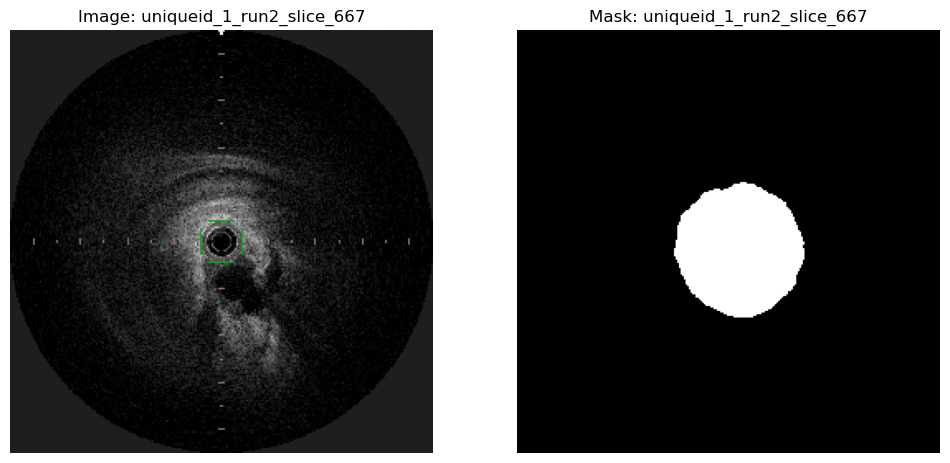

In [4]:
# Function for sanity check with plotting
def sanity_check(dataloader):
    for images, masks, filenames, unique_id in dataloader:
        print(f"Image batch shape: {images.shape}")
        print(f"Mask batch shape: {masks.shape}")
        # Just display a single sample from the batch
        print(f"Single image shape: {images[0].shape}")
        print(f"Single mask shape: {masks[0].shape}")
        print(f"Unique ID: {unique_id[0]}")
        
        # Plotting the image and the mask
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        
        ax[0].imshow(images[0].permute(1, 2, 0).numpy())  # Convert from CHW to HWC for plotting
        ax[0].set_title(f"Image: {filenames[0]}")
        ax[0].axis('off')
        
        ax[1].imshow(masks[0].squeeze().numpy(), cmap='gray')  # Squeeze to remove channel dimension
        ax[1].set_title(f"Mask: {filenames[0]}")
        ax[1].axis('off')
        
        plt.show()
        break  # Display just the first batch for the sanity check

# Run sanity checks
print("Sanity check for gentuity train dataset:")
sanity_check(train_loader_gentuity)

print("\nSanity check for gentuity test dataset:")
sanity_check(test_loader_gentuity)

print("\nSanity check for terumo dataset:")
sanity_check(train_loader_terumo)

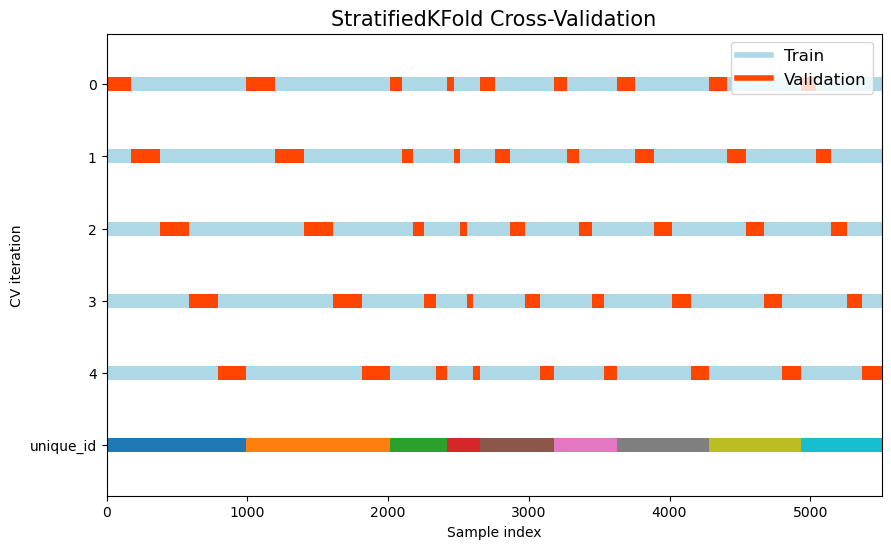

Sanity check for the first split:
Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])
Single image shape: torch.Size([3, 256, 256])
Single mask shape: torch.Size([1, 256, 256])
Unique ID: 0


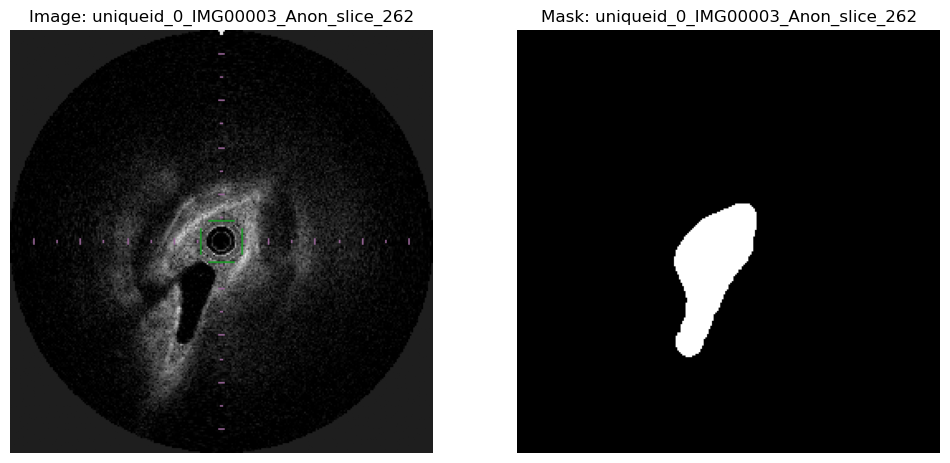

Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])
Single image shape: torch.Size([3, 256, 256])
Single mask shape: torch.Size([1, 256, 256])
Unique ID: 0


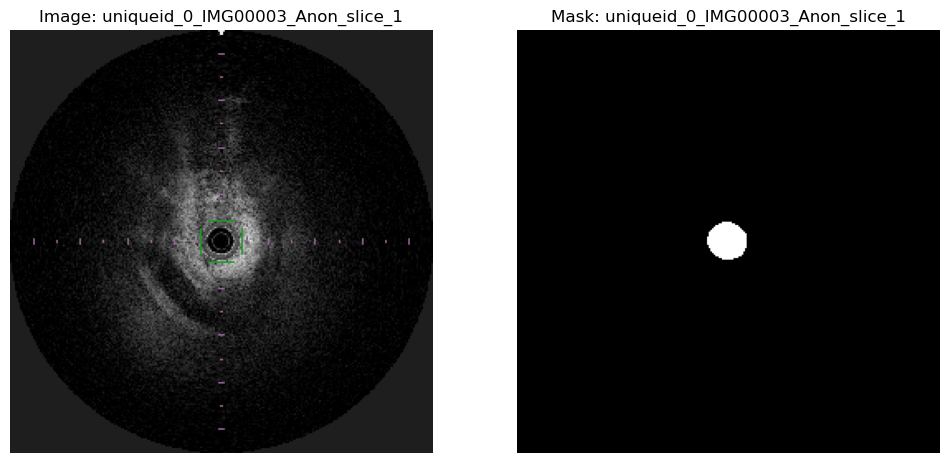

In [ ]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image


# Define the root directory
root_dir = r"C:\Users\johan\OneDrive - Aarhus universitet\9. Semester\Deep Learning\data_terumo"

# Define the transformation using Compose
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),   # Resize images to a specific size using nearest interpolation
    transforms.ToTensor(),            # Convert image to Tensor (0 to 1 range)
])

# Load metadata for use in dataset creation
metadata_df = pd.read_csv(root_dir + "/metadata.csv")

# Define the StratifiedKFold split
skf = StratifiedKFold(n_splits=5)
splits = list(skf.split(metadata_df, metadata_df["unique_id"]))

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

def plot_cv_indices(cv, X, y, ax, n_splits, lw=10, cmap_data="tab10"):
    """Create a sample plot for indices of a cross-validation object."""
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1  # Mark the test samples
        indices[tr] = 0  # Mark the train samples

        # Visualize the results for the current split
        # Train samples in light blue, validation samples in redder orange
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=np.where(indices == 0, '#add8e6', '#ff4500'),  # Set light blue and redder orange
            marker="_",
            lw=lw,
        )

    # Plot the unique_id at the end (instead of class labels)
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    # Add a legend for train and validation splits
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='#add8e6', lw=4, label='Train'),
        Line2D([0], [0], color='#ff4500', lw=4, label='Validation'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

    # Formatting
    yticklabels = list(range(n_splits)) + ["unique_id"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 1.2, -0.2],
        xlim=[0, len(X)],
    )
    ax.set_title(f"{type(cv).__name__} Cross-Validation", fontsize=15)
    return ax

# Visualize splits
def visualize_cv_splits(metadata_df, n_splits=9):
    # Extract unique IDs and their corresponding target (unique_id)
    unique_ids = metadata_df["unique_id"].values

    # Initialize StratifiedKFold with n_splits
    skf = StratifiedKFold(n_splits=n_splits)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the cross-validation splits
    plot_cv_indices(
        skf, X=metadata_df, y=unique_ids, ax=ax, n_splits=n_splits
    )

    plt.show()

# Call the function to visualize the splits
visualize_cv_splits(metadata_df, n_splits=5)

# Example: Load the first split
train_indices, val_indices = splits[0]
train_dataset = OCTDataset(root_dir, indices=train_indices, transform=transform)
val_dataset = OCTDataset(root_dir, indices=val_indices, transform=transform)

# Use DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Sanity check for the first split
print("Sanity check for the first split:")
sanity_check(train_loader)
sanity_check(val_loader)

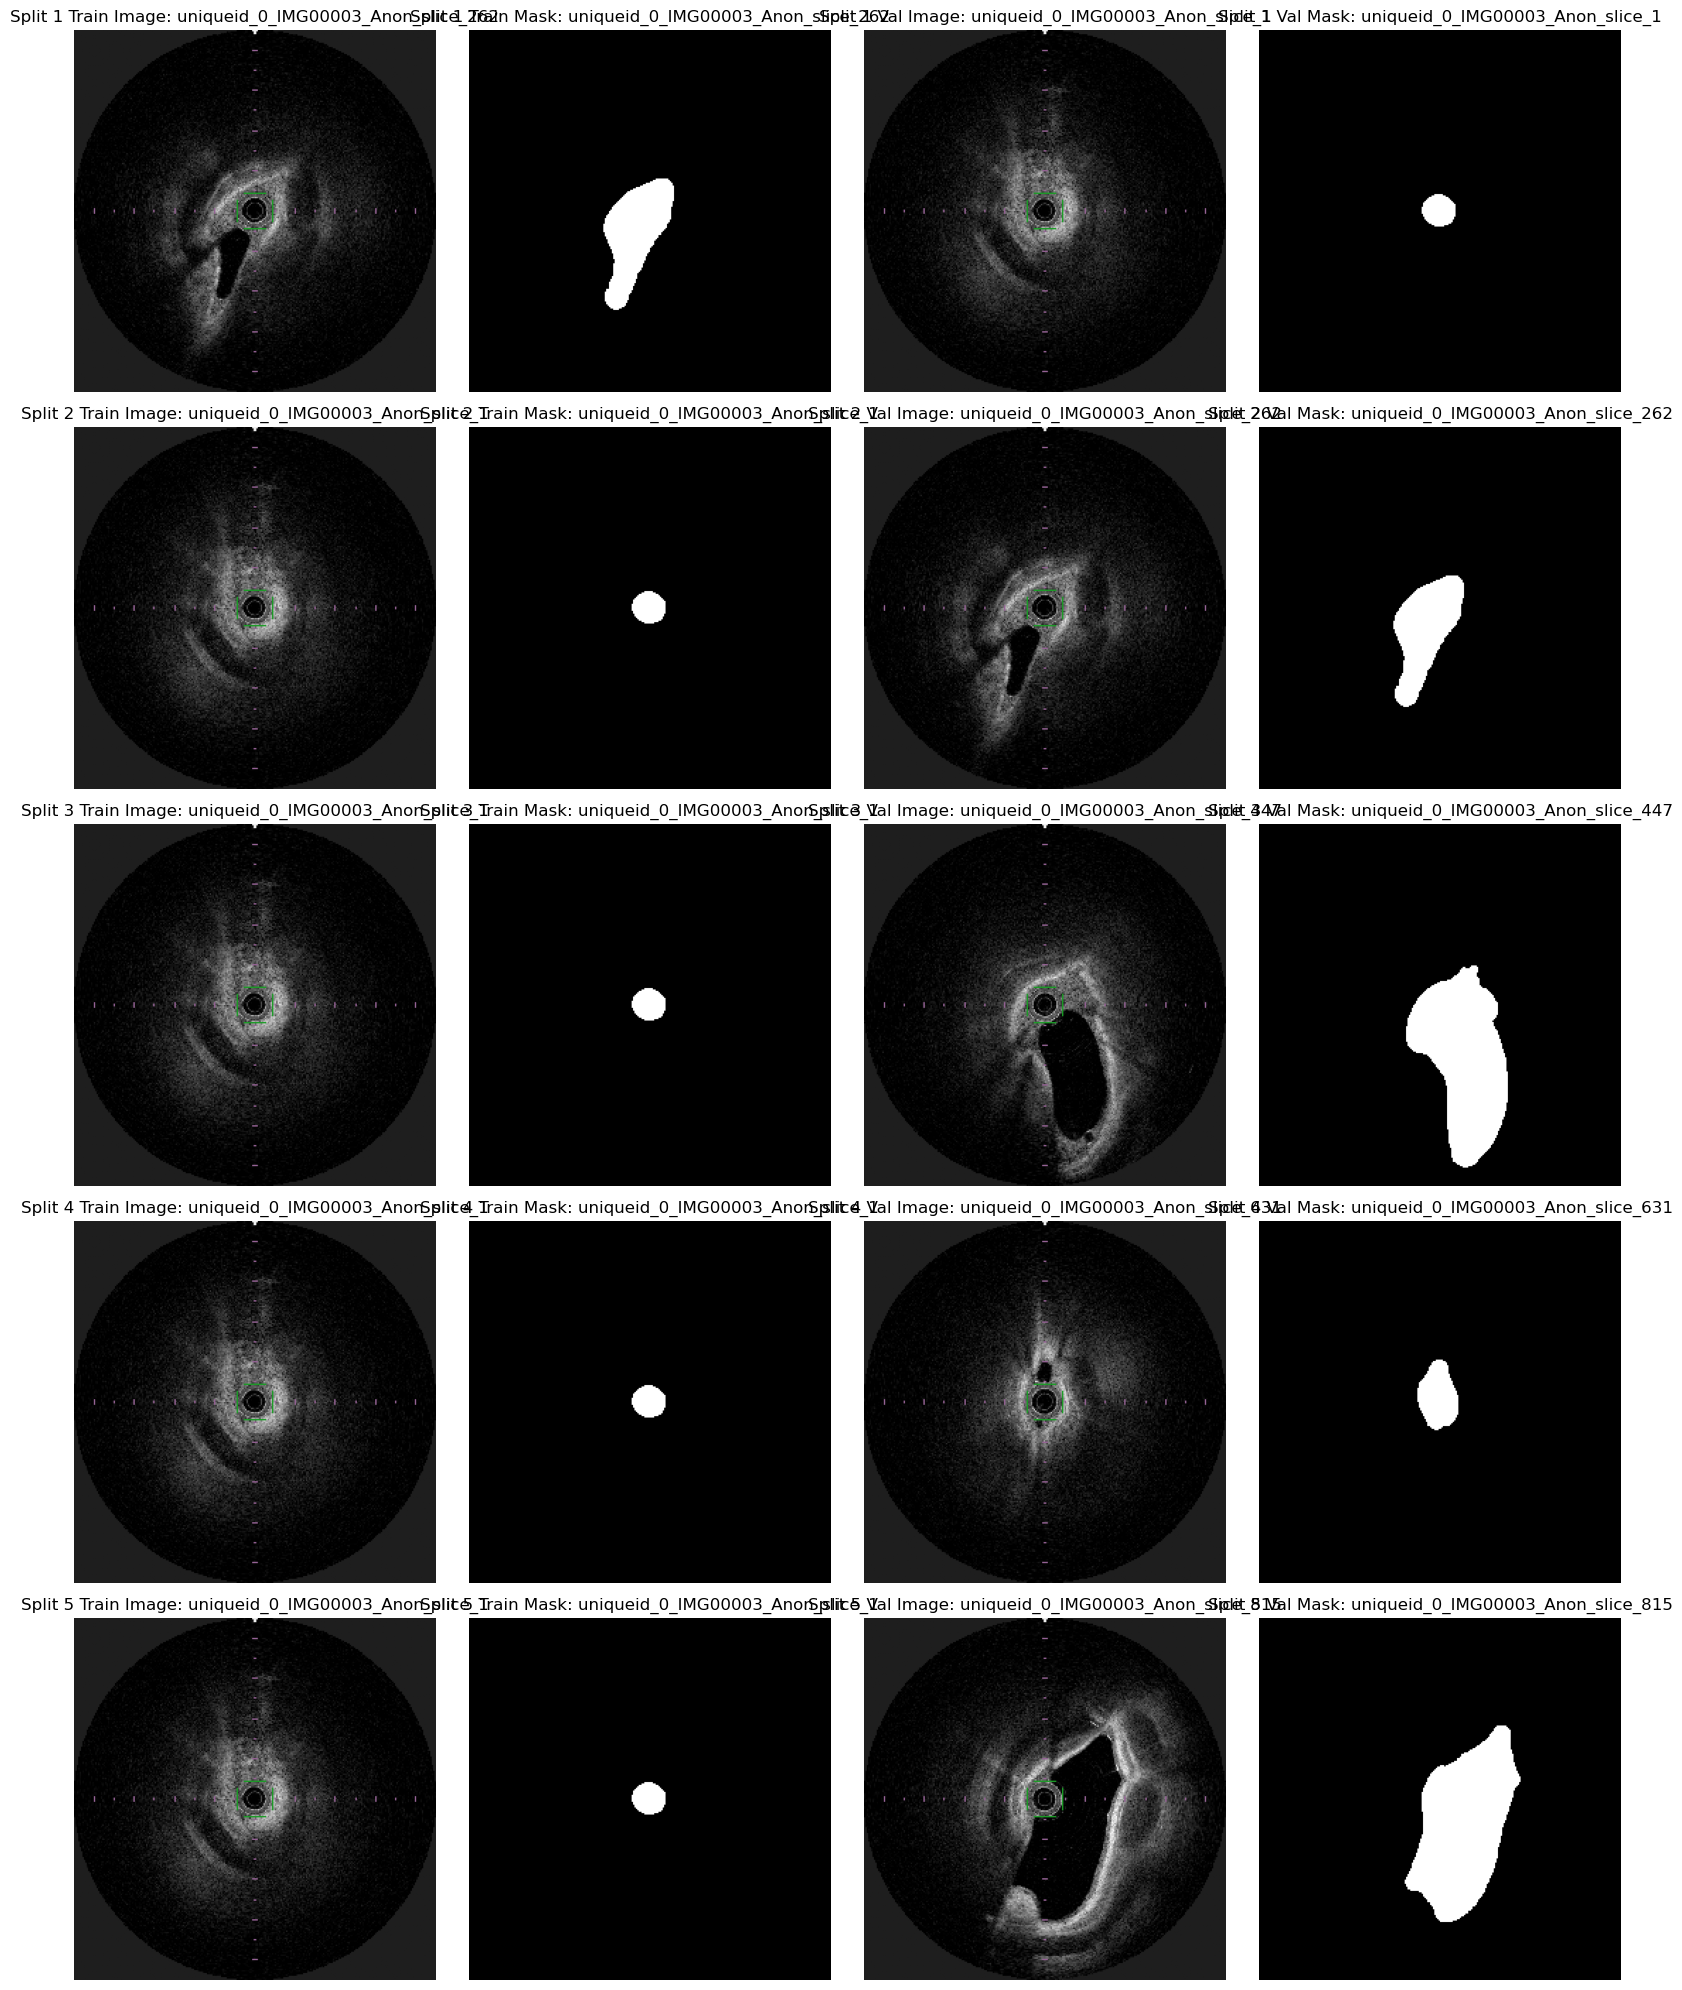

In [6]:
# Iterate through all splits and perform sanity check
fig, axs = plt.subplots(len(splits), 4, figsize=(16, 4 * len(splits)))

for i, (train_indices, val_indices) in enumerate(splits):  
    # Create datasets for the current split
    train_dataset = OCTDataset(root_dir, indices=train_indices, transform=transform)
    val_dataset = OCTDataset(root_dir, indices=val_indices, transform=transform)
    
    # Create dataloaders for the current split
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
    
    # Perform sanity check for training data
    for images, masks, filenames, unique_id in train_loader:
        axs[i, 0].imshow(images[0].permute(1, 2, 0).numpy())
        axs[i, 0].set_title(f"Split {i+1} Train Image: {filenames[0]}")
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(masks[0].squeeze().numpy(), cmap='gray')
        axs[i, 1].set_title(f"Split {i+1} Train Mask: {filenames[0]}")
        axs[i, 1].axis('off')
        break  # Display just the first batch for the sanity check
    
    # Perform sanity check for validation data
    for images, masks, filenames, unique_id in val_loader:
        axs[i, 2].imshow(images[0].permute(1, 2, 0).numpy())
        axs[i, 2].set_title(f"Split {i+1} Val Image: {filenames[0]}")
        axs[i, 2].axis('off')
        
        axs[i, 3].imshow(masks[0].squeeze().numpy(), cmap='gray')
        axs[i, 3].set_title(f"Split {i+1} Val Mask: {filenames[0]}")
        axs[i, 3].axis('off')
        break  # Display just the first batch for the sanity check

plt.tight_layout()
plt.show()